In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pq.read_table('data/df_train.parquet').to_pandas()
df_test = pq.read_table('data/df_test.parquet').to_pandas()

In [3]:
df_train.head()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.0,3.0,3.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
11528,6.0,1.0,1.0,2,0.5,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
26630,1.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
12586,6.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
11225,3.0,0.0,2.0,1,1.0,NaN,0.0,NaN,NaN,1.0,...,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04


## Entendimiento y preparación de datos

In [4]:
df_train.describe()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,RIESGOS,CANTIDAD_SERVICIOS,PERDIDA_DE_PESO,TIEMPO_ULTIMA_CITA,conteo_dx_diferentes,TIEMPO_AFILIACION,Target,Pendiente,Intercepto,Promedio_costo
count,23494.000000,23494.000000,23494.000000,23494.000000,23494.000000,8.000000,23494.000000,164.000000,164.000000,23494.000000,...,7211.000000,23494.000000,5771.000000,23494.000000,23494.000000,23494.000000,23494.000000,2.349400e+04,2.349400e+04,2.349400e+04
mean,5.201669,1.285094,1.244190,2.451392,0.227974,95.000000,0.000341,8.538970,2.986841,0.291947,...,1.492997,8.861156,0.170005,2.219928,2.918532,135.953520,0.284626,1.485093e+04,1.495688e+05,3.107291e+05
std,8.830948,2.669005,1.337775,1.153336,0.485658,86.194133,0.018450,44.400913,4.734082,0.454761,...,0.792335,12.090472,8.040427,3.991257,2.193799,104.881494,0.451246,4.270672e+05,1.854731e+06,1.424497e+06
min,0.000000,0.000000,0.000000,1.000000,0.000000,23.000000,0.000000,0.005000,0.000000,0.000000,...,1.000000,1.000000,-62.500000,1.000000,1.000000,7.000000,0.000000,-2.030057e+07,-3.337852e+07,1.000000e+00
25%,0.000000,0.000000,0.000000,2.000000,0.000000,41.000000,0.000000,0.978750,0.845750,0.000000,...,1.000000,2.000000,-2.560000,1.000000,1.000000,38.000000,0.000000,-4.412050e+03,-1.678853e+04,3.267192e+04
50%,2.000000,0.000000,1.000000,2.000000,0.000000,73.000000,0.000000,2.420000,1.785000,0.000000,...,1.000000,5.000000,0.000000,1.000000,2.000000,103.000000,0.000000,3.118857e+03,4.090667e+03,7.961250e+04
75%,6.000000,1.000000,2.000000,3.000000,0.333333,102.250000,0.000000,4.995000,3.552500,1.000000,...,2.000000,11.000000,2.270000,2.000000,4.000000,244.000000,1.000000,1.459710e+04,7.573733e+04,1.793700e+05
max,91.000000,44.000000,23.000000,10.000000,6.000000,284.000000,1.000000,550.000000,49.000000,2.000000,...,8.000000,262.000000,157.140000,36.000000,25.000000,350.000000,1.000000,1.490708e+07,1.013168e+08,9.516344e+07


In [5]:
# get null values per column
df_train.isnull().sum()

MEDICAMENTOS                         0
MEDICINA ESPECIALIZADA               0
MEDICINA GENERAL                     0
Cant_gr_flia                         0
Cant_riesgos_flia_mean               0
min_Tiempo_CP_Fliar              23486
Cant_Fliar_CP                        0
psa_max_gr_flia                  23330
psa_min_gr_flia                  23330
Cant_Fliar_riesgos                   0
cantidad_serv_flia                   0
Pendiente_flia                       0
Intercepto_flia                      0
Promedio_costo_flia                  0
ESTADO_CIVI                          0
PROGRAMA                             0
estrato                              0
IMC                              10364
AGRUPACION_SISTOLICA              3320
AGRUPACION_DIASTOLICA             3320
parentesco                           0
EDAD                                 0
RIESGOS                          16283
CANTIDAD_SERVICIOS                   0
PERDIDA_DE_PESO                  17723
TIEMPO_ULTIMA_CITA       

In [6]:
# show the no null df_train['min_Tiempo_CP_Fliar']
df_train[df_train['min_Tiempo_CP_Fliar'].notnull()]['min_Tiempo_CP_Fliar']

ID
2040      80.0
31015    284.0
22231     23.0
17706     46.0
13338     87.0
1671      26.0
8816      66.0
7196     148.0
Name: min_Tiempo_CP_Fliar, dtype: float64

In [7]:
# Select only numeric columns
numeric_df = df_train.select_dtypes(include=['float64', 'int64'])


correlation_matrix = numeric_df.corr()

correlation_matrix



,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,EDAD,RIESGOS,CANTIDAD_SERVICIOS,PERDIDA_DE_PESO,TIEMPO_ULTIMA_CITA,conteo_dx_diferentes,TIEMPO_AFILIACION,Pendiente,Intercepto,Promedio_costo
MEDICAMENTOS,1.000000,0.331966,0.346059,-0.015767,0.371614,0.695983,0.009245,-0.013971,-0.027956,0.357199,...,0.113124,0.377758,0.612828,-0.027119,-0.042176,0.566136,0.018647,-0.011508,0.116113,0.121762
MEDICINA ESPECIALIZADA,0.331966,1.000000,0.129245,0.011969,0.178686,0.737621,0.017045,0.036545,-0.023520,0.163898,...,0.023354,0.160557,0.687308,0.002429,-0.097833,0.573364,0.037938,-0.006058,0.166837,0.217455
MEDICINA GENERAL,0.346059,0.129245,1.000000,-0.042558,0.096550,0.461383,0.010427,0.067307,0.062067,0.105518,...,0.008977,0.030664,0.388879,0.006403,-0.169069,0.442487,-0.045967,-0.000503,0.036462,0.029684
Cant_gr_flia,-0.015767,0.011969,-0.042558,1.000000,-0.225905,-0.020829,0.016781,-0.060778,-0.130187,-0.023462,...,-0.103675,0.044259,-0.015832,-0.030073,0.018722,-0.019230,0.191894,0.002699,-0.013514,-0.019755
Cant_riesgos_flia_mean,0.371614,0.178686,0.096550,-0.225905,1.000000,0.304156,-0.003517,-0.043661,-0.049443,0.731039,...,0.095760,0.465987,0.282375,-0.002263,-0.008023,0.222321,0.004889,-0.017130,0.090760,0.091223
min_Tiempo_CP_Fliar,0.695983,0.737621,0.461383,-0.020829,0.304156,1.000000,NaN,-0.339025,-0.140208,0.422714,...,-0.344192,-0.633000,0.737751,0.999203,-0.205217,0.666525,0.478542,0.874465,-0.868506,0.874545
Cant_Fliar_CP,0.009245,0.017045,0.010427,0.016781,-0.003517,NaN,1.000000,0.023342,-0.058842,0.003371,...,-0.006026,-0.004111,0.020248,-0.003366,-0.002173,0.016460,0.008433,0.010363,-0.004086,0.004863
psa_max_gr_flia,-0.013971,0.036545,0.067307,-0.060778,-0.043661,-0.339025,0.023342,1.000000,0.813872,-0.070896,...,0.034120,-0.017410,0.002910,-0.194678,-0.040942,-0.000894,0.042279,0.015499,-0.035937,-0.020689
psa_min_gr_flia,-0.027956,-0.023520,0.062067,-0.130187,-0.049443,-0.140208,-0.058842,0.813872,1.000000,-0.123574,...,0.083655,0.015039,-0.047103,-0.242213,-0.062555,-0.024445,-0.017917,-0.026866,-0.021488,-0.036650
Cant_Fliar_riesgos,0.357199,0.163898,0.105518,-0.023462,0.731039,0.422714,0.003371,-0.070896,-0.123574,1.000000,...,0.083898,0.021855,0.262561,-0.015209,0.001677,0.210846,0.046084,-0.003914,0.051992,0.051208


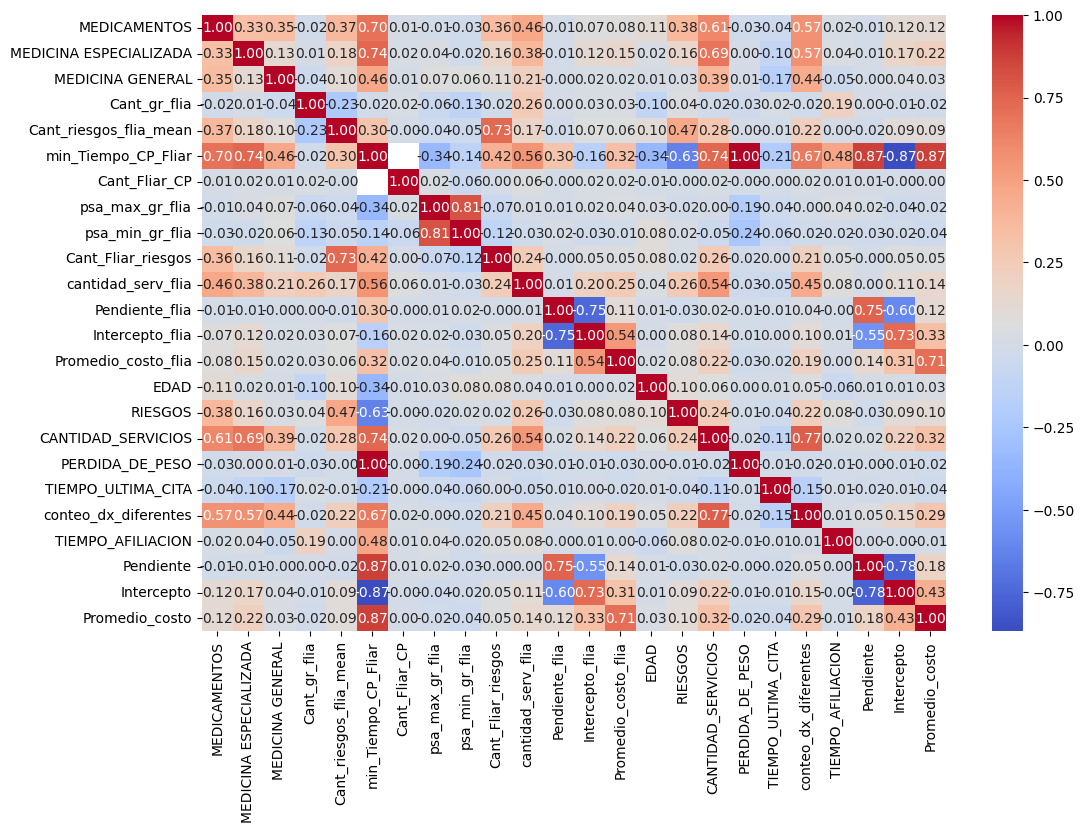

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### Dimensionality Reduction

In [9]:
threshold = 0.8

corr_matrix = numeric_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

correlated_pairs = []

for column in upper.columns:
    high_corr = upper[column][upper[column] > threshold]
    if not high_corr.empty:
        correlated_pairs.append((column, high_corr.idxmax(), high_corr.max()))
print("Highly correlated pairs:")
for col, corr_col, corr_value in correlated_pairs:
    print(f"{col}-------------------------------- {corr_col}=========> (correlation = {corr_value:.2f})")
    print(f"Null values in {col}: {df_train[col].isnull().sum()}")
    print(f"Null values in {corr_col}: {df_train[corr_col].isnull().sum()}")
    print('=========')


Highly correlated pairs:
psa_min_gr_flia-------------------------------- psa_max_gr_flia=========> (correlation = 0.81)
Null values in psa_min_gr_flia: 23330
Null values in psa_max_gr_flia: 23330
PERDIDA_DE_PESO-------------------------------- min_Tiempo_CP_Fliar=========> (correlation = 1.00)
Null values in PERDIDA_DE_PESO: 17723
Null values in min_Tiempo_CP_Fliar: 23486
Pendiente-------------------------------- min_Tiempo_CP_Fliar=========> (correlation = 0.87)
Null values in Pendiente: 0
Null values in min_Tiempo_CP_Fliar: 23486
Intercepto-------------------------------- min_Tiempo_CP_Fliar=========> (correlation = 0.87)
Null values in Intercepto: 0
Null values in min_Tiempo_CP_Fliar: 23486
Promedio_costo-------------------------------- min_Tiempo_CP_Fliar=========> (correlation = 0.87)
Null values in Promedio_costo: 0
Null values in min_Tiempo_CP_Fliar: 23486


Based on the high correlations and the number of null values, I would make the following decisions:

### 1. **psa_min_gr_flia vs. psa_max_gr_flia**:
   - **Correlation**: 0.81, which is quite high.
   - **Null values**: Both columns have the same number of missing values (23,330).
   
   **Decision**: Drop `psa_min_gr_flia` and keep `psa_max_gr_flia`.
   - Reason: These columns are highly correlated, and keeping both adds redundancy. Since both have the same number of nulls, it's safe to drop one, and `psa_max_gr_flia` may represent a more useful or meaningful metric (max PSA levels typically indicate higher risk in clinical contexts).

### 2. **PERDIDA_DE_PESO vs. min_Tiempo_CP_Fliar**:
   - **Correlation**: 1.00, which indicates perfect correlation.
   - **Null values**: `PERDIDA_DE_PESO` has 17,723 nulls, while `min_Tiempo_CP_Fliar` has 23,486 nulls.
   
   **Decision**: Drop `PERDIDA_DE_PESO` and keep `min_Tiempo_CP_Fliar`.
   - Reason: Since the correlation is perfect (1.00), both variables convey the same information. Given that `min_Tiempo_CP_Fliar` has more null values, it might indicate a more precise variable, representing time intervals for family prostate cancer diagnosis, which could be a stronger predictor in prostate cancer cases than weight loss.

### 3. **Pendiente vs. min_Tiempo_CP_Fliar**:
   - **Correlation**: 0.87, a very strong positive correlation.
   - **Null values**: `Pendiente` has no nulls, while `min_Tiempo_CP_Fliar` has 23,486 nulls.
   
   **Decision**: Drop `min_Tiempo_CP_Fliar` and keep `Pendiente`.
   - Reason: Since `Pendiente` has no null values and provides the same information as `min_Tiempo_CP_Fliar` (with a correlation of 0.87), it is a more complete variable. `min_Tiempo_CP_Fliar` has significant null values, which makes it less reliable.

### 4. **Intercepto vs. min_Tiempo_CP_Fliar**:
   - **Correlation**: 0.87, also very strong.
   - **Null values**: `Intercepto` has no nulls, while `min_Tiempo_CP_Fliar` has 23,486 nulls.
   
   **Decision**: Drop `min_Tiempo_CP_Fliar` and keep `Intercepto`.
   - Reason: Same as above. Since `Intercepto` has no nulls and has a high correlation with `min_Tiempo_CP_Fliar`, it’s better to keep `Intercepto`.

### 5. **Promedio_costo vs. min_Tiempo_CP_Fliar**:
   - **Correlation**: 0.87, similar to `Pendiente` and `Intercepto`.
   - **Null values**: `Promedio_costo` has no nulls, while `min_Tiempo_CP_Fliar` has 23,486 nulls.
   
   **Decision**: Drop `min_Tiempo_CP_Fliar` and keep `Promedio_costo`.
   - Reason: Again, due to the high correlation and the fact that `Promedio_costo` has no nulls, it’s more reliable to keep `Promedio_costo` and drop `min_Tiempo_CP_Fliar`.

### Final Decisions:
- **Drop**:
   - `psa_min_gr_flia`
   - `PERDIDA_DE_PESO`
   - `min_Tiempo_CP_Fliar` (since it's correlated with multiple columns and has many nulls)

- **Keep**:
   - `psa_max_gr_flia`
   - `Pendiente`
   - `Intercepto`
   - `Promedio_costo`

By dropping the columns with high correlations and keeping the most complete and relevant columns, you reduce redundancy and improve the dataset’s quality for further analysis or modeling. Let me know if you need further adjustments!

In [10]:
to_drop = ['psa_min_gr_flia','PERDIDA_DE_PESO', 'min_Tiempo_CP_Fliar']
df_train.drop(to_drop, axis=1, inplace=True)


In [11]:
len(df_train.columns)

43

In [12]:
df_train.isnull().sum()[df_train.isnull().sum() > 0]

psa_max_gr_flia          23330
IMC                      10364
AGRUPACION_SISTOLICA      3320
AGRUPACION_DIASTOLICA     3320
RIESGOS                  16283
CANCER_MAMA_FAMILIAR      6802
dtype: int64

In [13]:
df_train[df_train.isnull().sum()[df_train.isnull().sum() > 0].index]

,psa_max_gr_flia,IMC,AGRUPACION_SISTOLICA,AGRUPACION_DIASTOLICA,RIESGOS,CANCER_MAMA_FAMILIAR
ID,,,,,,
16484,NaN,Sobrepeso,Normal,Normal,NaN,0
11528,NaN,Sobrepeso,Normal,Normal,NaN,0
26630,NaN,Sobrepeso,Normal,Normal,NaN,0
12586,NaN,Sobrepeso,Normal,Normal,NaN,0
11225,NaN,Obesidad,Normal,Normal,1.0,None
...,...,...,...,...,...,...
7141,NaN,Bajo peso,Normal,Normal,NaN,0
15417,NaN,Sobrepeso,Normal,Normal,1.0,None
19389,NaN,Sobrepeso,Normal,Hipotenso,NaN,None


## Pipeline to input columns
- Vamos a imputar features numericas y categoricas de manera separada en un pipeline

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

X = df_train.drop(columns=['Target'])
y = df_train['Target']

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

X_imputed = preprocessor.fit_transform(X)
categorical_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)

all_feature_names = np.concatenate([numeric_cols, categorical_feature_names])

X_imputed_df = pd.DataFrame(X_imputed, columns=all_feature_names)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_imputed_df, y, test_size=0.2, random_state=42)

import xgboost as xgb
from sklearn.metrics import r2_score

xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgboost_model.fit(X_train_final, y_train_final)

y_pred_final = xgboost_model.predict(X_test_final)

r2_final = r2_score(y_test_final, y_pred_final)
print(f"R² score on test data using imputed dataset: {r2_final:.4f}")


Shape of original df_train (excluding Target): (23494, 42)
Shape of X_imputed_df after preprocessing: (23494, 97)
R² score on test data using imputed dataset: 0.2270


## Baseline using XG-Boost

In [37]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_imputed_df, y, test_size=0.2, random_state=42)
xgboost_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgboost_classifier.fit(X_train_final, y_train_final)
y_pred_final = xgboost_classifier.predict(X_test_final)
accuracy = accuracy_score(y_test_final, y_pred_final)
precision = precision_score(y_test_final, y_pred_final)
recall = recall_score(y_test_final, y_pred_final)
f1 = f1_score(y_test_final, y_pred_final)

# Print classification metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.7908
Precision: 0.7447
Recall: 0.4161
F1 Score: 0.5339
